In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spcphys_common_functions as scf
from datetime import datetime
from cdasws import CdasWs
cdas = CdasWs()
from astropy import units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicCarrington
from matplotlib import pyplot as plt
import numpy as np

In [3]:
TIME_RANGE = [datetime(2022, 3, 1), datetime(2022, 8, 1)]

_, solo_pos_data = cdas.get_data(dataset='SOLO_HELIO1DAY_POSITION', variables=['HG_LAT', 'HG_LON', 'RAD_AU'], time0=TIME_RANGE[0], time1=TIME_RANGE[1])
_, solo_mrg_data = cdas.get_data(dataset='SOLO_COHO1HR_MERGED_MAG_PLASMA', variables=['VR'], time0=TIME_RANGE[0], time1=TIME_RANGE[1])
_, psp_pos_data = cdas.get_data(dataset='PSP_HELIO1DAY_POSITION', variables=['HG_LAT', 'HG_LON', 'RAD_AU'], time0=TIME_RANGE[0], time1=TIME_RANGE[1])

In [4]:
base_sc_obs_time = scf.preprocess.npdt64_to_dt(solo_mrg_data['Epoch'].values)
base_sc_pos_time = scf.preprocess.npdt64_to_dt(solo_pos_data['Epoch'].values)
base_sc_obs_lon = (np.angle(scf.preprocess.interpolate(base_sc_obs_time, base_sc_pos_time, np.exp(1j*np.deg2rad(solo_pos_data['HG_LON'].values))), deg=True) + 360) % 360 * u.deg
base_sc_obs_lat = (np.angle(scf.preprocess.interpolate(base_sc_obs_time, base_sc_pos_time, np.exp(1j*np.deg2rad(solo_pos_data['HG_LAT'].values))), deg=True)) * u.deg
base_sc_obs_r = scf.preprocess.interpolate(base_sc_obs_time, base_sc_pos_time, solo_pos_data['RAD_AU'].values * u.au)
base_sc_obs_pos = SkyCoord(lon=base_sc_obs_lon, lat=base_sc_obs_lat, radius=base_sc_obs_r, frame=HeliographicCarrington, obstime=base_sc_obs_time)

In [5]:
target_sc_obs_pos = SkyCoord(lon=psp_pos_data['HG_LON'].values * u.deg, lat=psp_pos_data['HG_LAT'].values * u.deg, radius=psp_pos_data['RAD_AU'].values * u.au, frame=HeliographicCarrington, obstime=scf.preprocess.npdt64_to_dt(psp_pos_data['Epoch'].values))

In [6]:
time_psp, lon_diff = scf.backmapping.dual_spacecraft_obs_diff(pos_sat1=base_sc_obs_pos, 
                                                                pos_sat2=target_sc_obs_pos,
                                                                v_r=solo_mrg_data['VR'].values * u.km/u.s,
                                                                # v_r = 400 * u.km/u.s,
                                                                num_processes=0.9)

Backmapping: 100%|██████████| 3673/3673 [00:19<00:00, 192.68data/s]
/opt/miniconda3/envs/spcphys/lib/python3.11/site-packages/spcphys_common_functions/processing/backmapping.py:178: UserWarning: Failed to backmap 882 data points.
  warnings.warn(f'Failed to backmap {failed_backmap.sum()} data points.')


Text(0, 0.5, 'Rad [au]')

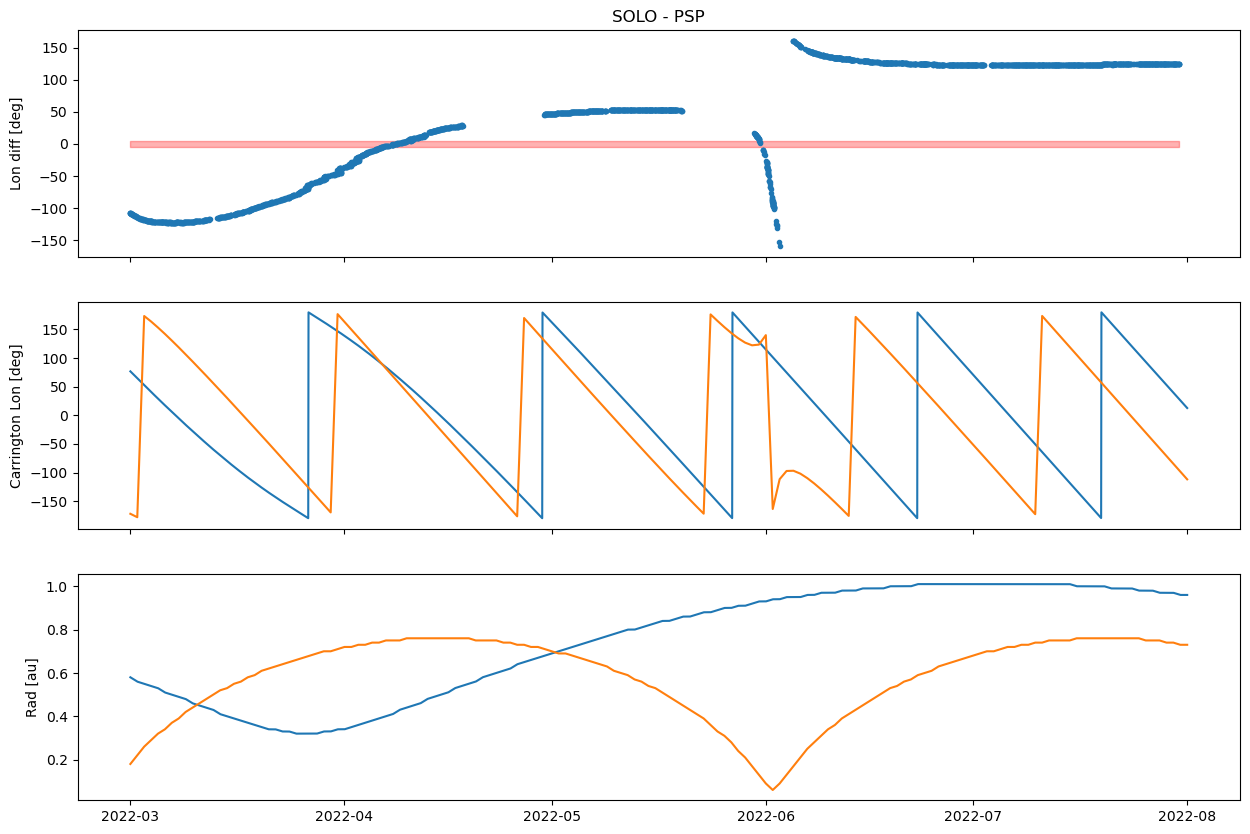

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
ax[0].set_title('SOLO - PSP')

ax[0].plot(time_psp, lon_diff, marker='.', ls='')
ax[0].fill_between((time_psp[0], time_psp[-1]), -5, 5, color='red', alpha=0.3)
ax[0].set_ylabel('Lon diff [deg]')

base_lon = base_sc_obs_pos.lon.to_value()
base_lon[base_lon > 180] -= 360
ax[1].plot(base_sc_obs_pos.obstime.value, base_lon)
target_lon = target_sc_obs_pos.lon.to_value()
target_lon[target_lon > 180] -= 360
ax[1].plot(target_sc_obs_pos.obstime.value, target_lon)
ax[1].set_ylabel('Carrington Lon [deg]')

ax[2].plot(base_sc_obs_pos.obstime.value, base_sc_obs_pos.radius.to_value())
ax[2].plot(target_sc_obs_pos.obstime.value, target_sc_obs_pos.radius.to_value())
ax[2].set_ylabel('Rad [au]')